In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
from sqlalchemy.sql.expression import desc


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import Column, Integer, String, Date, Text, Float
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()
Base = automap_base()

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()
date_str = '2010-01-01'
date_obj = datetime.strptime(date_str, '%Y-%m-%d')

In [5]:
# reflect an existing database into a new model
class hawaiimeasure(Base):
    __tablename__ = 'measure'
    id= Column(Integer, primary_key=True )
    station = Column(Text)
    prcp = Column(Float)
    date = Column(Text)
    tobs = Column(Float)
class hawaiistation(Base):
    __tablename__ = 'Station'
    id = Column(Integer, primary_key=True)
    station = Column(Text)
    name= Column(Text)
    latitude = Column(Float)
    longitude = Column(Float)
    elevation = Column(Float)
# reflect the tables
Base.metadata.create_all(conn)

In [6]:
Base.prepare(conn, reflect=True)
HawaiiMeasure = Base.classes.measurement
HawaiiStation = Base.classes.station
session = Session(conn)

# Query data from the reflected models
results = session.query(HawaiiMeasure).all()

# Access attributes of the reflected model
# for result in results:
#     print(result.station, result.date, result.prcp, result.tobs)

In [7]:
# View all of the classes that automap found

Base = automap_base()
Base.prepare(autoload_with= engine)
Base.classes.keys()

['Measure', 'measurement', 'station']

In [8]:

session.commit()

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
latest_date= session.query(HawaiiMeasure.date).order_by(HawaiiMeasure.date.desc()).first()
latest_date


('2017-08-23',)

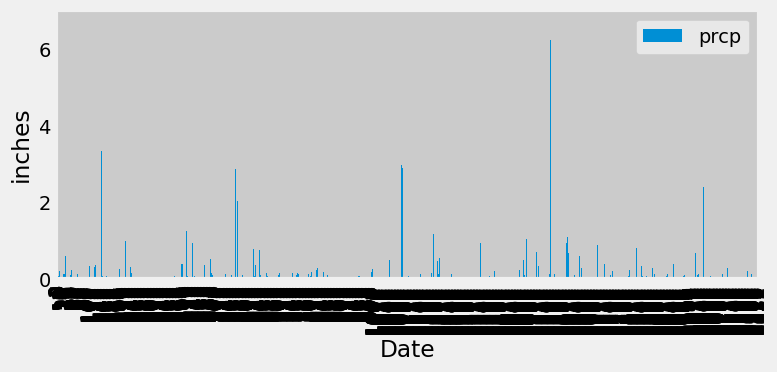

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
df1 = session.query(HawaiiMeasure.date) \
    .filter(HawaiiMeasure.date > '2016-08-23') \
    .order_by(HawaiiMeasure.date) \
    .all()

# print(df1)
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
last_date = dt.date(2017, 8, 23)
year_ago = last_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(HawaiiMeasure.date, HawaiiMeasure.prcp) \
    .filter(HawaiiMeasure.date > year_ago) \
    .order_by(HawaiiMeasure.date) \
    .all()
# print(prcp_data)
prcp_data_df= pd.DataFrame(prcp_data)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(prcp_data_df, columns=['date', 'prcp'])
df.plot.bar(figsize=(8,4))
df.set_index('date', inplace=True)
plt.xlabel("Date")
plt.ylabel("inches")
plt.tight_layout()
plt.show()
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = prcp_data_df.describe()

print(summary_statistics)

              prcp
count  2015.000000
mean      0.176462
std       0.460288
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query(HawaiiStation).group_by(HawaiiStation.station).count()


9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
stations= session.query(HawaiiMeasure.station, func.count(HawaiiMeasure.station)).\
          group_by(HawaiiMeasure.station).\
          order_by(desc(func.count(HawaiiMeasure.station))).all()
stations
# List the stations and their counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperate= [func.min(HawaiiMeasure.tobs),
            func.max(HawaiiMeasure.tobs),
            func.avg(HawaiiMeasure.tobs)]
temperate

[<sqlalchemy.sql.functions.min at 0x7fb8495ae200; min>,
 <sqlalchemy.sql.functions.max at 0x7fb862407580; max>,
 <sqlalchemy.sql.functions.Function at 0x7fb862407640; avg>]

Text(0, 0.5, 'Frequency')

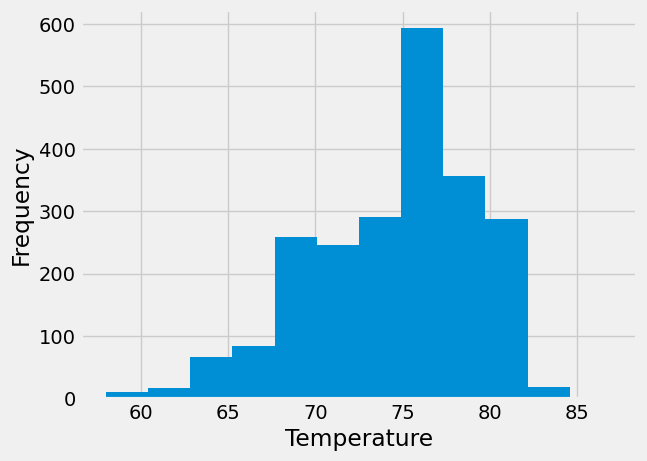

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = session.query(HawaiiMeasure.tobs).\
                                filter(HawaiiMeasure.date >= year_ago).\
                                order_by(HawaiiMeasure.date.desc()).all()
temp
temp_obs_df = pd.DataFrame(temp)
plt.hist(temp_obs_df['tobs'], bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")


# Close Session

In [16]:
# Close Session
session.close()